In [11]:
import scipy
import statsmodels
import sklearn
import theano
import tensorflow
import keras

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
#read data
df = pd.read_csv('E:/SUMO/RUIXIAO/newChattanooganet/Data/output/Gillig501Feb2020W2.csv', index_col=False)
print(len(df))
df.columns

274569


Index(['Unnamed: 0', 'Unix.Timestamp..ms.', 'Time..US.Eastern.',
       'Analysis...fuel...Fuel.used..gal.',
       'Analysis...other...Distance.driven..mi.',
       'Vehicle...Acceleratorpedal.Position....',
       'Engine...Engine.Fuel.Rate..gal.h.', 'Engine...Engine.Speed..rpm.',
       'Vehicle...Wheel.Based.Vehicle.Speed..mi.h.', 'GPS...Altitude..m.',
       'GPS...GPS.position.Latitude', 'GPS...GPS.position.Longitude'],
      dtype='object')

In [3]:
#process raw data
df.columns =['idx','Timestamp', 'Time', 'FuelUsed', 
             'Dist', 'AccP','FuelRate','RPM', 'speed', 
             'Alt', 'Lat', 'Long', ]
df = df[['speed', 'FuelRate']]
df['speed'] = df['speed']*1.60934 #convert mph to km/h
df['FuelRate'] = df['FuelRate']*3.78541 #convert gal/hr to liter/hr
df = df.drop(df[df.FuelRate == 0].index)

In [4]:
#interpolate if raw data is unfilled
FuelRate = df['FuelRate']
FuelRate = FuelRate.interpolate()
df['FuelRate'] = FuelRate
Speed = df['speed']
Speed = Speed.interpolate()
df['speed'] = Speed

In [5]:
#get acceleration
speedms = df['speed']*1000/3600
df['acceleration']=speedms.diff() #unit: m/s2
df=df.dropna()

In [6]:
#split train and test datasets
train = df.sample(n=math.floor(0.8*df.shape[0]))
test = df.sample(n=math.ceil(0.2*df.shape[0]))

In [7]:
#build ann model
Y_train = train['FuelRate'] #unit: l/h
X_train = train[['speed','acceleration']]
Y_test = test['FuelRate']
X_test = test[['speed','acceleration']]
model = Sequential()
model.add(Dense(5,kernel_initializer='normal', input_dim=2, activation ='relu'))
model.add(Dense(5, kernel_initializer='normal', activation ='relu'))
model.add(Dense(1,kernel_initializer='normal', activation ='linear'))
model.compile(loss='mean_absolute_error', optimizer='adam')


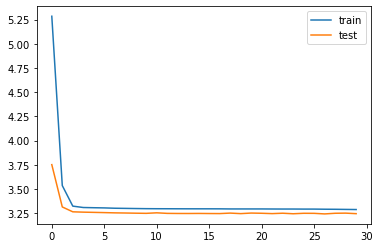

In [8]:
#fit model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=256, verbose = 0)
#performance
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [12]:
#read trajectory data that needs prediction
trip = pd.read_csv("E:/SUMO/RUIXIAO/newChattanooganet/Data/output/Traj6-7/Route10A_trip151970020_060600.csv")
trip['speed']=trip['speed']*(0.01*3.6) 
#km/h
trip['acceleration']=trip['acceleration']*(0.001) 
#m/s2
input2esti=trip[['speed','acceleration']]

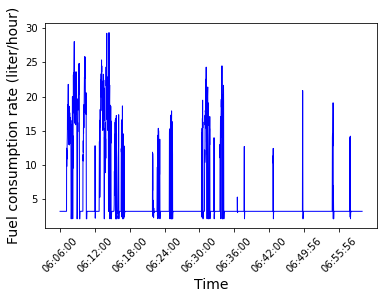

In [13]:
#prdiction and plot results
pre = model.predict(input2esti)
tripf=pd.concat([trip,pd.DataFrame(pre,columns=['FuelRate'])], axis=1) 

fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(tripf.index, tripf.FuelRate, color='blue', linewidth=1)
ax1.set_xticks(tripf.index[::360])
ax1.set_xticklabels(tripf.time[::360], rotation=45)
plt.tight_layout(pad=4)
plt.subplots_adjust(bottom=0.15)
plt.xlabel("Time",fontsize = 14)
plt.ylabel("Fuel consumption rate (liter/hour)",fontsize = 14)
plt.show()